### TODO
- Date Format nicht notwendig, MESS_DATUM ist bereits numerisches Feature

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def create_lag_features(data, lag_days, variables):
    for l in range(1,lag_days+1):
        for variable in variables:
            data[f'{variable}_lag_{l}'] = data[variable].shift(-l)
    return data

# Kapitel 1: Datenvorbereitung
1. Erstelle einen DataFrame für jede Wetterstation
2. Filtere die DataFrames auf einen Zeitraum, in dem für alle Orte Werte vorhanden sind
3. Kombiniere die Data Frames anhand von Datumsfeature 
4. Erstelle TimeLag Features
5. Fülle Fehlende Daten mit sinnvollen werten oder entferne Sie

In [56]:
def replace_missing_values(value, df, row, col):
    if value != -999:
        return value

    def replacement_logic(column, row, col):
        nonlocal value

        # Berücksichtige nur 10 Werte über und unter dem Datenpunkt
        start_index = max(0, row - 10)
        end_index = min(len(column), row + 10)
        distances = np.abs(np.arange(start_index, end_index) - row)/home/sohler/Documents/UNI/ML/project/Weather_Forecast_ML/data/Timings_sorted.csv

        non_missing_values = column[column != -999]

        if non_missing_values.size > 0:
            distances = distances[:non_missing_values.size]
            weights = np.exp(-0.1 * distances)
            weighted_mean = np.convolve(non_missing_values, weights, mode='valid')[0] / np.sum(weights)
            return round(weighted_mean,2)

        return -999

    # Nur den berechneten Wert zurückgeben
    return replacement_logic(df.iloc[:, col].values, row, col)

In [57]:
file_path_ort1 = 'data/Schorndorf.csv'
file_path_ort2 = 'data/Arber.csv'
file_path_ort3 = 'data/Straubing.csv'

# Laden der Daten und Filtern nach Zeitraum
df_sch = pd.read_csv(file_path_ort1)
df_sch = df_sch[df_sch[' MESS_DATUM'] >= 19960501].drop(['DATE'], axis=1)
df_arb = pd.read_csv(file_path_ort2)
df_arb = df_arb[df_arb[' MESS_DATUM'] >= 19960501].drop(['DATE'], axis=1)
df_str = pd.read_csv(file_path_ort3)
df_str = df_str[df_str[' MESS_DATUM'] >= 19960501].drop(['DATE'], axis=1)

#Zusammenführen der DataFrames
df_combined = pd.merge(df_sch, df_arb, how='inner', on=' MESS_DATUM', suffixes=('_sch', '_arb'))
df_combined = pd.merge(df_combined, df_str, how='inner', on=' MESS_DATUM')
df_combined.columns = df_combined.columns.str.strip()
#Erstelle Feature für jeden vorherzusagenden Tag für beide Zielgrößen
df_combined_tl = create_lag_features(df_combined, lag_days=3, variables=['NIEDERSCHLAGSHOEHE', 'LUFTTEMPERATUR'])
df_combined_tl.drop(df_combined_tl.tail(3).index, inplace=True)

#drop columns with only NaN
df_combined_tl = df_combined.drop(['LUFTDRUCK_STATIONSHOEHE_sch', 'WINDGESCHWINDIGKEIT_sch',
                                   'WINDSPITZE_MAXIMUM_sch', 'SONNENSCHEINDAUER_sch', 
                                   'LUFTTEMP_AM_ERDB_MINIMUM_arb'], axis=1) 

#missing value replacement: filling with weighted avg
for row in range(df_combined_tl.shape[0]):
    for col in range(df_combined_tl.shape[1]):
        df_combined_tl.iloc[row, col] = replace_missing_values(df_combined_tl.iloc[row, col],
                                                                 df_combined_tl, row, col) 

print(df_combined_tl.head)

<bound method NDFrame.head of       MESS_DATUM  QUALITAETS_NIVEAU_sch  LUFTTEMPERATUR_sch  DAMPFDRUCK_sch  \
0       19960501                     10                11.4            10.9   
1       19960502                     10                11.6            11.6   
2       19960503                     10                 9.6             9.9   
3       19960504                     10                 8.6             9.2   
4       19960505                     10                 7.6             7.6   
...          ...                    ...                 ...             ...   
7176    20151224                      1                 6.6             8.6   
7177    20151225                      1                 9.0             8.3   
7178    20151226                      1                 6.0             7.6   
7179    20151227                      1                 3.0             6.6   
7180    20151228                      1                -0.1             5.8   

      BEDECKUNGSGRAD_

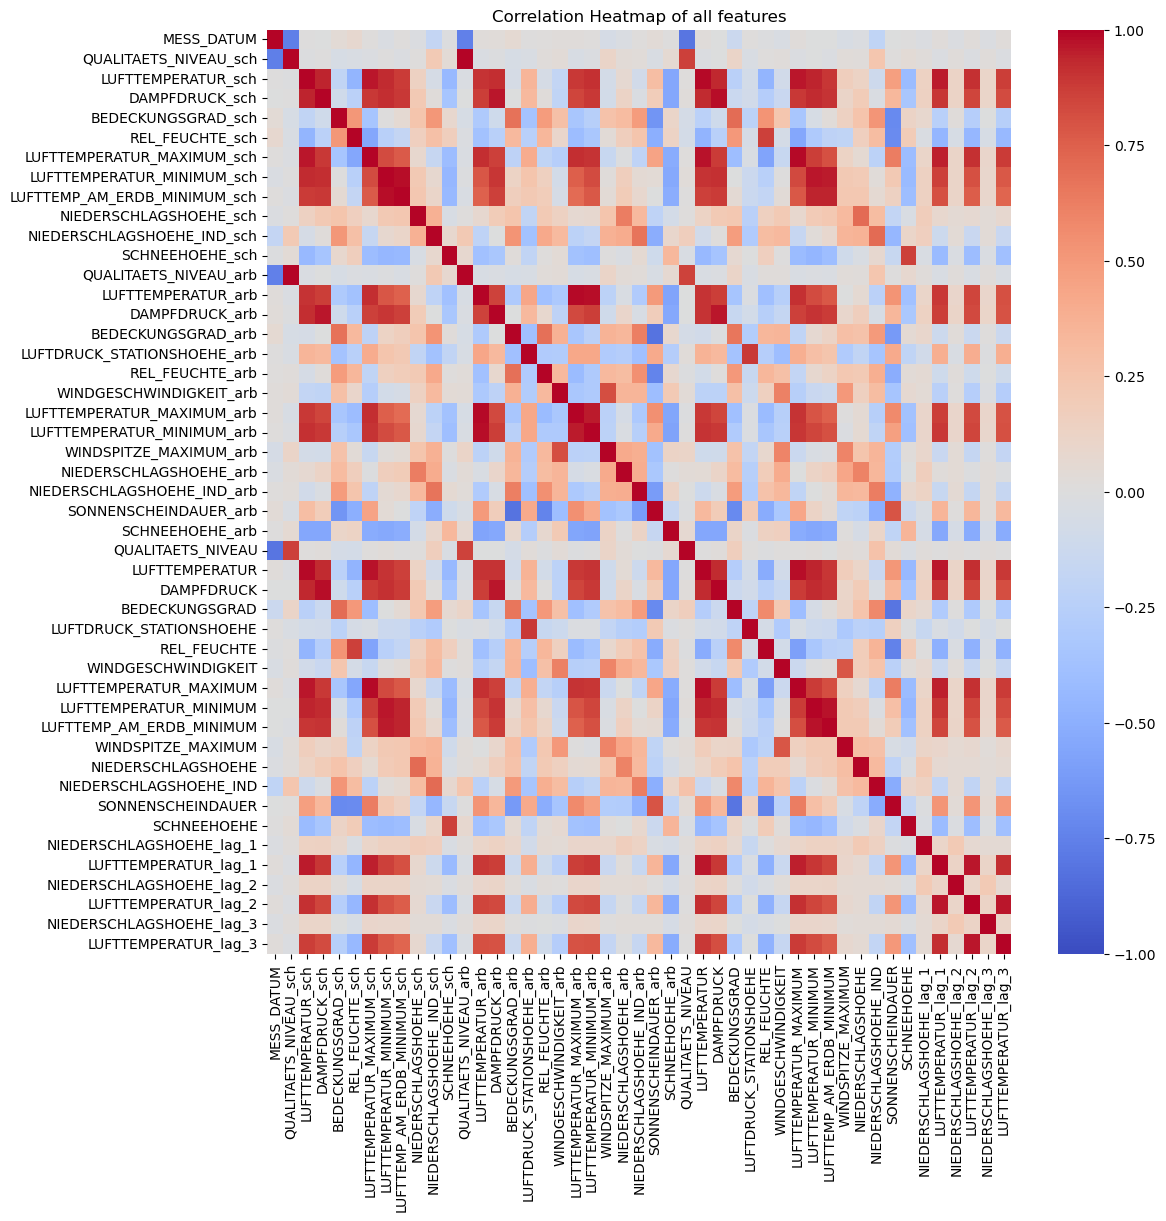

In [58]:
# Plot the corelation-heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(df_combined_tl.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of all features')
plt.savefig('heatmap_cleaned.png')
plt.show()

### TODO
- Prüfen, ob miteinbeziehen des Qualitätsniveaus die Vorhersage verbessert

# Kapitel 2: Lineares Modell

### TODO
- test size variieren
- Wieso ist test-mse besser als train-mse

In [8]:

from pathlib import Path
cwd = str(Path.cwd())

X = pd.read_csv(cwd + "/../data/Featchers_randomized.csv")
df_combined_tl = pd.read_csv(cwd + "/../data/Goals_randomized.csv")


y1_lag1 = df_combined_tl['straubing_LUFTTEMPERATUR_future_1Day']
y1_lag2 = df_combined_tl['straubing_LUFTTEMPERATUR_future_2Day']
y1_lag3 = df_combined_tl['straubing_LUFTTEMPERATUR_future_3Day']
y2_lag1 = df_combined_tl['straubing_NIEDERSCHLAGSHOEHE_future_1Day']
y2_lag2 = df_combined_tl['straubing_NIEDERSCHLAGSHOEHE_future_2Day']
y2_lag3 = df_combined_tl['straubing_NIEDERSCHLAGSHOEHE_future_3Day']

# Train-Test-Split für jede Zeitverzögerung
X_train_lag1, X_test_lag1, y1_lag1_train, y1_lag1_test, y2_lag1_train, y2_lag1_test = train_test_split(X, y1_lag1, y2_lag1, test_size=0.20)
X_train_lag2, X_test_lag2, y1_lag2_train, y1_lag2_test, y2_lag2_train, y2_lag2_test = train_test_split(X, y1_lag2, y2_lag2, test_size=0.20)
X_train_lag3, X_test_lag3, y1_lag3_train, y1_lag3_test, y2_lag3_train, y2_lag3_test = train_test_split(X, y1_lag3, y2_lag3, test_size=0.20)

# Train Model für Lag 1 und mache Vorhersagen
model_lag1_y1 = LinearRegression()
model_lag1_y1.fit(X_train_lag1, y1_lag1_train)
y1_lag1_train_pred = model_lag1_y1.predict(X_train_lag1)
y1_lag1_test_pred = model_lag1_y1.predict(X_test_lag1)

model_lag1_y2 = LinearRegression()
model_lag1_y2.fit(X_train_lag1, y2_lag1_train)
y2_lag1_train_pred = model_lag1_y2.predict(X_train_lag1)
y2_lag1_test_pred = model_lag1_y2.predict(X_test_lag1)

# Train Model für Lag 2 und mache Vorhersagen
model_lag2_y1 = LinearRegression()
model_lag2_y1.fit(X_train_lag2, y1_lag2_train)
y1_lag2_train_pred = model_lag2_y1.predict(X_train_lag2)
y1_lag2_test_pred = model_lag2_y1.predict(X_test_lag2)

model_lag2_y2 = LinearRegression()
model_lag2_y2.fit(X_train_lag2, y2_lag2_train)
y2_lag2_train_pred = model_lag2_y2.predict(X_train_lag2)
y2_lag2_test_pred = model_lag2_y2.predict(X_test_lag2)

# Train Model für Lag 3 und mache Vorhersagen
model_lag3_y1 = LinearRegression()
model_lag3_y1.fit(X_train_lag3, y1_lag3_train)
y1_lag3_train_pred = model_lag3_y1.predict(X_train_lag3)
y1_lag3_test_pred = model_lag3_y1.predict(X_test_lag3)

model_lag3_y2 = LinearRegression()
model_lag3_y2.fit(X_train_lag3, y2_lag3_train)
y2_lag3_train_pred = model_lag3_y2.predict(X_train_lag3)
y2_lag3_test_pred = model_lag3_y2.predict(X_test_lag3)

# Berechne MSE für jede Zeitverzögerung und Zielgröße
mse_lag1_y1_train = mean_squared_error(y1_lag1_train, y1_lag1_train_pred)
mse_lag1_y1_test = mean_squared_error(y1_lag1_test, y1_lag1_test_pred)
mse_lag1_y2_train = mean_squared_error(y2_lag1_train, y2_lag1_train_pred)
mse_lag1_y2_test = mean_squared_error(y2_lag1_test, y2_lag1_test_pred)

mse_lag2_y1_train = mean_squared_error(y1_lag2_train, y1_lag2_train_pred)
mse_lag2_y1_test = mean_squared_error(y1_lag2_test, y1_lag2_test_pred)
mse_lag2_y2_train = mean_squared_error(y2_lag2_train, y2_lag2_train_pred)
mse_lag2_y2_test = mean_squared_error(y2_lag2_test, y2_lag2_test_pred)

mse_lag3_y1_train = mean_squared_error(y1_lag3_train, y1_lag3_train_pred)
mse_lag3_y1_test = mean_squared_error(y1_lag3_test, y1_lag3_test_pred)
mse_lag3_y2_train = mean_squared_error(y2_lag3_train, y2_lag3_train_pred)
mse_lag3_y2_test = mean_squared_error(y2_lag3_test, y2_lag3_test_pred)

r2_lag3_y2_train = r2_score(y2_lag3_train, y2_lag3_train_pred)
print(r2_lag3_y2_train)

0.03421563784140402


In [9]:
print("---------- MSE Temperatur Day Prediction: -----------")
print("MSE bei 1 tägiger Vorhersage (train):", mse_lag1_y1_train)
print("MSE bei 1 tägiger Vorhersage (test):", mse_lag1_y1_test)
print("MSE bei 2 tägiger Vorhersage (train):", mse_lag2_y1_train)
print("MSE bei 2 tägiger Vorhersage(test):", mse_lag2_y1_test)
print("MSE bei 3 tägiger Vorhersage (train):", mse_lag3_y1_train)
print("MSE bei 3 tägiger Vorhersage (test):", mse_lag3_y1_test)

print("----------- MSE Niederschlag Prediction: ------------")
print("MSE bei 1 tägiger Vorhersage (train):", mse_lag1_y2_train)
print("MSE bei 1 tägiger Vorhersage (test):", mse_lag1_y2_test)
print("MSE bei 2 tägiger Vorhersage (train):", mse_lag2_y2_train)
print("MSE bei 2 tägiger Vorhersage (test):", mse_lag2_y2_test)
print("MSE bei 3 tägiger Vorhersage (train):", mse_lag3_y2_train)
print("MSE bei 3 tägiger Vorhersage (test):", mse_lag3_y2_test)

---------- MSE Temperatur Day Prediction: -----------
MSE bei 1 tägiger Vorhersage (train): 3.9632961380740506
MSE bei 1 tägiger Vorhersage (test): 3.953242725606656
MSE bei 2 tägiger Vorhersage (train): 8.432258020012375
MSE bei 2 tägiger Vorhersage(test): 9.23910254223903
MSE bei 3 tägiger Vorhersage (train): 11.372503812431098
MSE bei 3 tägiger Vorhersage (test): 12.522030364601683
----------- MSE Niederschlag Prediction: ------------
MSE bei 1 tägiger Vorhersage (train): 16.132935465753068
MSE bei 1 tägiger Vorhersage (test): 14.191413243896875
MSE bei 2 tägiger Vorhersage (train): 15.55484363912379
MSE bei 2 tägiger Vorhersage (test): 20.9401720489073
MSE bei 3 tägiger Vorhersage (train): 16.623224113392148
MSE bei 3 tägiger Vorhersage (test): 17.321897087843737


### TODO
- wieso ist kaum ein unterschied zwischen den verschiedenen time lags vorhanden? 
- wieso immer noch keine vorhersage von Niederschlag mögl?

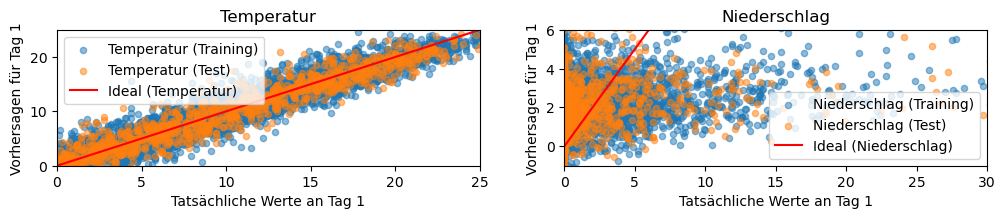

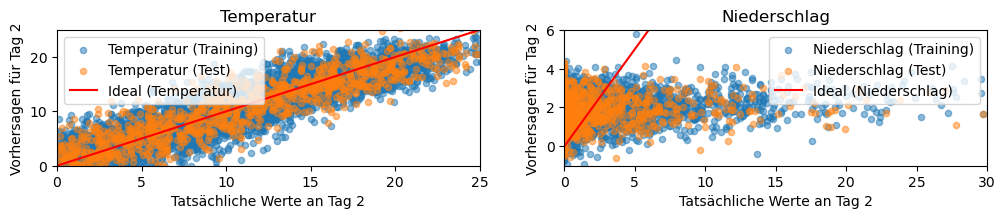

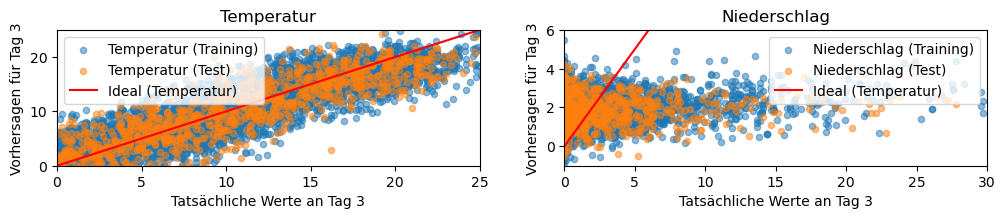

In [10]:
# Visualisiere die Abweichung der Vorhersagen von den tatsächlichen Werten für Temperatur an Tag1
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
plt.scatter(y1_lag1_train, y1_lag1_train_pred, label='Temperatur (Training)', alpha=0.5, s=20)
plt.scatter(y1_lag1_test, y1_lag1_test_pred, label='Temperatur (Test)', alpha=0.5, s=20)
max_value_y1_lag1 = max(max(y1_lag1_train), max(y1_lag1_test), max(y1_lag1_train_pred), max(y1_lag1_test_pred))
plt.plot([-10, max_value_y1_lag1], [-10, max_value_y1_lag1], linestyle='-', color='red', label='Ideal (Temperatur)')
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.xlabel('Tatsächliche Werte an Tag 1')
plt.ylabel('Vorhersagen für Tag 1')
plt.title('Temperatur')
plt.legend()

# Visualisiere die Abweichung der Vorhersagen von den tatsächlichen Werten für Niederschlag an Tag 1
plt.subplot(3, 2, 2)
plt.scatter(y2_lag1_train, y2_lag1_train_pred, label='Niederschlag (Training)', alpha=0.5, s=20)
plt.scatter(y2_lag1_test, y2_lag1_test_pred, label='Niederschlag (Test)', alpha=0.5, s=20)
max_value_y2_lag1 = max(max(y2_lag1_train), max(y2_lag1_test), max(y2_lag1_train_pred), max(y2_lag1_test_pred))
plt.plot([-10, max_value_y2_lag1], [-10, max_value_y2_lag1], linestyle='-', color='red', label='Ideal (Niederschlag)')
plt.xlim(0, 30)
plt.ylim(-1, 6)
plt.xlabel('Tatsächliche Werte an Tag 1')
plt.ylabel('Vorhersagen für Tag 1')
plt.title('Niederschlag')
plt.legend()

# Visualisiere die Abweichung der Vorhersagen von den tatsächlichen Werten für Temperatur an Tag 2
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 3)
plt.scatter(y1_lag2_train, y1_lag2_train_pred, label='Temperatur (Training)', alpha=0.5, s=20)
plt.scatter(y1_lag2_test, y1_lag2_test_pred, label='Temperatur (Test)', alpha=0.5, s=20)
max_value_y1_lag2 = max(max(y1_lag2_train), max(y1_lag2_test), max(y1_lag2_train_pred), max(y1_lag2_test_pred))
plt.plot([-10, max_value_y1_lag2], [-10, max_value_y1_lag2], linestyle='-', color='red', label='Ideal (Temperatur)')
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.xlabel('Tatsächliche Werte an Tag 2')
plt.ylabel('Vorhersagen für Tag 2')
plt.title('Temperatur')
plt.legend()

# Visualisiere die Abweichung der Vorhersagen von den tatsächlichen Werten für Niederschlag
plt.subplot(3, 2, 4)
plt.scatter(y2_lag2_train, y2_lag2_train_pred, label='Niederschlag (Training)', alpha=0.5, s=20)
plt.scatter(y2_lag2_test, y2_lag2_test_pred, label='Niederschlag (Test)', alpha=0.5, s=20)
max_value_y2_lag2 = max(max(y2_lag2_train), max(y2_lag2_test), max(y2_lag2_train_pred), max(y2_lag2_test_pred))
plt.plot([-10, max_value_y2_lag2], [-10, max_value_y2_lag2], linestyle='-', color='red', label='Ideal (Niederschlag)')
plt.xlim(0, 30)
plt.ylim(-1, 6)
plt.xlabel('Tatsächliche Werte an Tag 2')
plt.ylabel('Vorhersagen für Tag 2')
plt.title('Niederschlag')
plt.legend()

# Visualisiere die Abweichung der Vorhersagen von den tatsächlichen Werten für Temperatur
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 5)
plt.scatter(y1_lag3_train, y1_lag3_train_pred, label='Temperatur (Training)', alpha=0.5, s=20)
plt.scatter(y1_lag3_test, y1_lag3_test_pred, label='Temperatur (Test)', alpha=0.5, s=20)
max_value_y1_lag3 = max(max(y1_lag3_train), max(y1_lag3_test), max(y1_lag3_train_pred), max(y1_lag3_test_pred))
plt.plot([-10, max_value_y1_lag3], [-10, max_value_y1_lag3], linestyle='-', color='red', label='Ideal (Temperatur)')
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.xlabel('Tatsächliche Werte an Tag 3')
plt.ylabel('Vorhersagen für Tag 3')
plt.title('Temperatur')
plt.legend()

# Visualisiere die Abweichung der Vorhersagen von den tatsächlichen Werten für Niederschlag
plt.subplot(3, 2, 6)
plt.scatter(y2_lag3_train, y2_lag3_train_pred, label='Niederschlag (Training)', alpha=0.5, s=20)
plt.scatter(y2_lag3_test, y2_lag3_test_pred, label='Niederschlag (Test)', alpha=0.5, s=20)
max_value_y2_lag3 = max(max(y2_lag3_train), max(y2_lag3_test), max(y2_lag3_train_pred), max(y2_lag3_test_pred))
plt.plot([-10, max_value_y2_lag3], [-10, max_value_y2_lag3], linestyle='-', color='red', label='Ideal (Temperatur)')
plt.xlim(0, 30)
plt.ylim(-1, 6)
plt.xlabel('Tatsächliche Werte an Tag 3')
plt.ylabel('Vorhersagen für Tag 3')
plt.title('Niederschlag')
plt.legend()

plt.show()

In [8]:
#Diese Zelle für plot bzgl. MSE
#Boxplot für MSE pro Tag und Zielgröße

## Temperatur
Linearer Zusammenhang deutlich erkennbar, MSE aber noch zu hoch? Modell grundsätzlich korrekt.

## Niederschlag
Vorhersage schwankt um Wert 2.
Modell schlecht, da kein Linearer Zusammenhang zwischen den Features (systematischer Fehler) vor 3 Tagen und dem Niederschlag heute besteht. Time Lag zu groß, daher keine korelation (auch erkennbar in heatmap)

### TODO
- Verbesserung der Ergebnisse der Multivarianten Linearen Regression durch verwendung der Polynomialen Regression als Erweiterung

### 2. Lineares Modell Lasso/Ridge Regression ???

